In [32]:
import yfinance as yf
from langchain_core.tools import tool
from typing import List, Tuple


@tool(return_direct=True, response_format="content_and_artifact")
def fetch_stock_data(tickers: List[str], period='1y') -> Tuple[str, dict]:
    """
    Fetch historical stock data for a list of tickers over a specified period.

    Args:
        tickers: A list of stock ticker symbols.
        period: The period over which to fetch the stock data (default is '1y').
    
    Returns:
        dict: A dictionary where the keys are ticker symbols and the values are the historical stock data.
    """
    data = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        history = stock.history(period=period)
        data[ticker] = history.reset_index().to_dict(orient='list')
    response = f"The data for tickers: {tickers} retrieved successfully for period: {period}"
    return response, data

In [ ]:
fetch_stock_data.get_input_schema().model_json_schema()

In [ ]:
fetch_stock_data.tool_call_schema(tickers=["TSLA", "AAPL"]).model_json_schema()

In [ ]:
tickers = ["TSLA", "AAPL"]
result= fetch_stock_data.invoke({"tickers": tickers, "period": "1y"})
print(result)

In [ ]:
# for ticker, history in data.items():
#     print(f"{ticker}: {history.keys()}")
#     print(f"Sample Data: {history}")

In [ ]:
import numpy as np
import pandas as pd


def compute_metrics(data: dict) -> dict:
    """
    Computes the Annual returns and Volatility metrics from the data.

    Args:
        data: The Data dictionary
    
    Returns:
        results: A dictionary of computed metrics
    """
    results = {}
    for ticker, history in data.items():
        # print(f"\nProcessing: {ticker}")
        # print(f"Available keys: {history.keys()}")
        
        # Convert history to DataFrame
        df = pd.DataFrame.from_dict(history)

        # Check for 'Close' prices
        if 'Close' not in df.columns or df['Close'].dropna().empty:
            print(f"Warning: No closing price data for {ticker}")
            continue
        
        # Calculate metrics
        returns = np.log(df['Close'] / df['Close'].shift(1)).dropna()
        annual_return = (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1) * 100
        volatility = returns.std() * np.sqrt(252) * 100
        
        # Store results
        results[ticker] = {
            "Annual Return": float(annual_return),   # Convert to Python float
            "Volatility": float(volatility)         # Convert to Python float
        }
    return results


In [ ]:
# metrics = compute_metrics.invoke(data)


# print(metrics)

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import Dict
from IPython.display import display, clear_output
from datetime import datetime

SAVE_DIR = 'charts'
os.makedirs(SAVE_DIR, exist_ok=True)

def visualize_trends(data: Dict) -> str:
    """ 
    Visualize the closing price trends for multiple stocks.

    Args:
        data: A dictionary containing the ticker symbols and their corresponding historical stock data.

    Returns:
        None: It displays a matplotlib chart.
    """
    if not data:
        print("No data to visualize.")
        return 
    
    # Create the figure
    plt.figure(figsize=(12, 6))
    for ticker, history in data.items():
        plt.plot(history['Date'], history['Close'], label=ticker)

    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title('Stock Price Trends')
    plt.grid(True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f"{SAVE_DIR}/stock_trend_{timestamp}.png"

    plt.savefig(file_name)
    plt.close()

    return f"Chart saved to: {file_name}"

In [ ]:
# visualize_trends(data)

In [4]:

from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

In [6]:
from langgraph.graph import StateGraph, MessagesState
from typing import TypedDict

class AgentState(MessagesState):
    next: str
    data: dict
    analysis: dict 
    summary: str

In [7]:
members = ["data_retriever", "analyzer", "visualizer", "allocator"]
# members = ["data_retriever", "analyzer", "allocator"]
options = members + ["FINISH"]

In [8]:
from typing import Literal

class Router(TypedDict):
    next: Literal[*options]

In [9]:
SUPERVISOR_PROMPT = """
You are a supervisor tasked with managing a conversation between the following workers: {members}. 
Given the current state and following user request, respond with the worker that needs to act next. 
Select the workers that are needed based on the feedback:
- "data_retriever" (to fetch the relevant stock data)
- "visualizer" (to visualize the fetched data)
- "analyzer" (to analyze the trends from the data)
- "allocator" (to suggest fund allocation in the sector)
Each worker will perform a task and respond with their results and status.
DO NOT CALL any agent MORE THAN ONCE.
When finished, respond with FINISH."""

In [10]:
DATA_RETRIEVER_PROMPT = """
You are a data retriever. You must call the fetch_stock_data tool to retrieve the historical stock data which the user requires.The tool argument should be LIST OF TICKERS given by user. ONLY OUTPUT tool_calls AND NOTHING ELSE.
"""

In [11]:
VISUALIZER_PROMPT = """
Your task is to find the data from the message history and then call visualize_trends tool. KEEP THE DATA AS IT IS DO NOT MAKE ANY CHANGES TO IT. Format is: '{'ticker_symbol: correspoding data'}' ONLY OUTPUT THE TOOL CALL AND NOTHING ELSE."""

In [12]:
# ANALYZER_PROMPT = """
# You are the Stock Data Analyzer. Your task is to assess stock performance by calculating key metrics like annual returns and volatility. Help users understand risk-reward characteristics of each stock.
# """

ANALYZER_PROMPT = """
You are the Stock Data Analyzer.Your task is to interpret stock performance metrics (annual return and volatility) given by the user to identify trends.

For each stock, classify the trend as one of the following:
- **Bullish:** Positive returns with moderate volatility.
- **Bearish:** Negative returns with high volatility.
- **Stable:** Low volatility with flat or minimal returns.
- **Speculative:** Positive returns with very high volatility.
If volatility is extremely high, flag the stock as high risk. Only return a short summary for each stock, without explanations or allocation recommendations.
"""

In [13]:
ALLOCATOR_PROMPT = """
You are the Fund Allocator. Your job is to recommend optimal fund allocations based on the findings and calculations given by the user.
"""

In [14]:

from langgraph.types import Command
from langchain_core.messages import SystemMessage
from langgraph.graph import END

def supervisor_node(state: AgentState) -> Command[Literal[*members, "__end__"]]:
    messages = [
        SystemMessage(content=SUPERVISOR_PROMPT.format(members=members)),
    ] + state["messages"]
    response = model.with_structured_output(Router, method="function_calling").invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END
    return Command(update={"next": goto}, goto=goto)

In [15]:
from langchain_core.messages import HumanMessage

data_retriever_agent = model.bind_tools([fetch_stock_data])

def data_retriever_node(state: AgentState) -> Command[Literal["supervisor"]]:
    data = {}
    messages = [
        SystemMessage(content=DATA_RETRIEVER_PROMPT),
    ] + state["messages"]
    ai_msg = data_retriever_agent.invoke(messages)
    messages.append(ai_msg)
    for tool_call in ai_msg.tool_calls:
        selected_tool = {"fetch_stock_data": fetch_stock_data}[tool_call["name"].lower()]
        tool_msg = selected_tool.invoke(tool_call)
        data = tool_msg.artifact
        messages.append(tool_msg)
    
    print(data)
    return Command(
        update={
            "messages": [HumanMessage(content=messages[-1].content, name="data_retriever")],
            "data": data,
        },
        goto="supervisor"
    )

In [16]:
from IPython.display import display, clear_output

visualizer_agent = model.bind_tools([visualize_trends])

def visualizer_node(state: AgentState) -> Command[Literal["supervisor"]]:
    data = state["data"]
    response = visualize_trends(data=data)
    
    return Command(
        update={
            "messages": [HumanMessage(content=response, name="visualizer")],
        },
        goto="supervisor"
    )

In [ ]:
# analyzer_agent = model.bind_tools([compute_metrics])

def analyzer_node(state: AgentState) -> Command[Literal["supervisor"]]:
    data = state["data"]
    print(type(data))
    metrics = compute_metrics(data)
    print(metrics)
    messages = [
        SystemMessage(content=ANALYZER_PROMPT),
        HumanMessage(content=f"Metrics: {metrics}"),
    ] + state["messages"]
    response = model.invoke(messages)
    return Command(
        update={
            "messages": [HumanMessage(content=response.content, name="analyzer")],
            "analysis": response.content
        },
        goto="supervisor"
    )

In [28]:
def allocator_node(state: AgentState) -> Command[Literal["supervisor"]]:
    analysis = state["analysis"]
    messages = [
        SystemMessage(content=ALLOCATOR_PROMPT),
    ] + state["messages"]
    response = model.invoke(messages)
    return Command(
        update={
            "messages": [HumanMessage(content=response.content, name="allocator")],
            "summary": response.content,
        },
        goto="supervisor"
    )

In [29]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("data_retriever", data_retriever_node)
graph_builder.add_node("visualizer", visualizer_node)
graph_builder.add_node("analyzer", analyzer_node)
graph_builder.add_node("allocator", allocator_node)
graph_builder.set_entry_point("supervisor")

graph = graph_builder.compile()

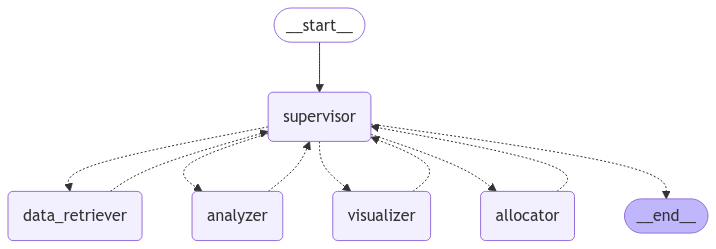

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [30]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Help me decide how to distribute investments across META and AMD")]}, subgraphs=True
):
    print(s)
    print("-"*50)

((), {'supervisor': {'next': 'data_retriever'}})
--------------------------------------------------
{'AMD': {'Date': [Timestamp('2024-02-28 00:00:00-0500', tz='America/New_York'), Timestamp('2024-02-29 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-01 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-04 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-05 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-06 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-07 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-08 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-11 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-12 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-13 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-14 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-15 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-18 00:00:00-0400', tz='America/New_York'), Timestamp('202

In [33]:
input = {"messages": [HumanMessage(content="Help me decide how to distribute investments across META, MSFT, and AMD.")]}
final_output = graph.invoke(input)

print(final_output['summary'])

{'META': {'Date': [Timestamp('2024-02-28 00:00:00-0500', tz='America/New_York'), Timestamp('2024-02-29 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-01 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-04 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-05 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-06 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-07 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-08 00:00:00-0500', tz='America/New_York'), Timestamp('2024-03-11 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-12 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-13 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-14 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-15 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-18 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-19 00:00:00-0400', tz='America/New_York'), Timestamp('2024-03-20 00:00:00-0400', tz='America/N

In [ ]:
input = {"messages": [HumanMessage(content="Which stocks should I invest in? Answer based on the last month.(1mo)")]}
final_output = graph.invoke(input)

print(final_output['summary'])